Creating a custom [text, abstract] dataset: 

In [ ]:
!pip install datasets csv json requests fitz tqdm re

In [ ]:
import json
import csv
import requests
import fitz  
from tqdm import tqdm
import re


input_json = "arxiv-metadata-oai-snapshot.json" #kaggle arxiv dataset - JSON 
output_csv = "training_data.csv"
skip_log = "skipped_papers.log"

max_papers = 2000

def download_pdf(paper_id):
    url = f"https://arxiv.org/pdf/{paper_id}.pdf"
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200: 
            return response.content
    except Exception:


        pass
    return None

def extract_text_from_pdf(pdf_bytes):
    try:
        doc = fitz.open(stream=pdf_bytes, filetype="pdf")
        text = ""
        for page in doc:
            text += page.get_text()

        return ' '.join(text.split())
    except Exception:
        return ""

#   >500 words in paper + >40 in abstract
def is_text_clean(text):
    if len(text.split()) < 500: 
        return False
    junk_ratio = sum(1 for c in text if not c.isalnum() and not c.isspace()) / len(text)
    return junk_ratio < 0.1

def has_embedded_abstract(text):
    match = re.search(r'\babstract\b[\s:]*([A-Z].{100,800})', text, re.IGNORECASE)
    if match:
        words = match.group(1).split()
        return len(words) >= 40
    return False


def main():
    count_saved = 0 #valid papers
    count_skipped = 0 #invalid papers

    with open(input_json, 'r', encoding='utf-8') as json_file, \
         open(output_csv, 'w', newline='', encoding='utf-8') as csv_file, \
         open(skip_log, 'w', encoding='utf-8') as log_file:

        writer = csv.writer(csv_file)
        writer.writerow(['paper_text', 'abstract'])




        for line in tqdm(json_file):
            if count_saved >= max_papers: #prevent overshooting
                break
            try:
                paper = json.loads(line)
                paper_id = paper.get("id", "").strip()
                abstract = paper.get("abstract", "").replace('\n', ' ').strip()
                abstract = ' '.join(abstract.split())

                # missing field or short abstract
                if not paper_id:
                    log_file.write(f"{paper_id or 'UNKNOWN_ID'}\missing paper id\n")
                    count_skipped += 1
                    continue
                if not abstract or len(abstract.split()) < 40:
                    log_file.write(f"{paper_id}\tabstract not good\n")
                    count_skipped += 1
                    continue

                pdf_bytes = download_pdf(paper_id)
                if pdf_bytes is None:
                    log_file.write(f"{paper_id}\tpdf failed\n")
                    count_skipped += 1
                    continue

                full_text = extract_text_from_pdf(pdf_bytes)
                if not full_text:
                    log_file.write(f"{paper_id}\tempty extracted text\n")
                    count_skipped += 1
                    continue

                if not is_text_clean(full_text):
                    log_file.write(f"{paper_id}\ttext not clean or too short\n")
                    count_skipped += 1
                    continue

                if not has_embedded_abstract(full_text):
                    log_file.write(f"{paper_id}\tembedded abstract missing or too short\n")
                    count_skipped += 1
                    continue

                # write valid papers to csv (saved papers)
                writer.writerow([full_text, abstract])
                count_saved += 1


            except Exception as e:
                log_file.write(f"{paper_id or 'UNKNOWN_ID'}\tSkipped: Exception {str(e)}\n")
                count_skipped += 1



    print(f"{count_saved} papers --> {output_csv}")
    print(f"{count_skipped} invalid papers --> {skip_log}")

if __name__ == "__main__":
    main()

MODEL:

In [ ]:
!pip install transformers datasets pandas accelerate rouge_score torch

Load and prepare dataset:

In [ ]:
import pandas as pd
from datasets import Dataset

#dataset format: paper_text,abstract



df = pd.read_csv("model_data.csv")

df = df[["paper_text", "abstract"]].dropna() #keep only filled columns and rows
df = df[df["paper_text"].str.len() > 2000] #remove any paper_text entries below 2000 characters

dataset = Dataset.from_pandas(df) #convert to a hugging face object


Enable the CUDA GPU

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda') 
    print(f"{torch.cuda.get_device_name(0)}")


Tokenize and train: 

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments


tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn") #https://huggingface.co/facebook/bart-large-cnn 

def preprocess(a):
    inputs = tokenizer( 
        a["paper_text"], max_length = 1024, truncation = True, padding= "max_length" #max input tokens = 1024
    )

    targets = tokenizer(
        a["abstract"], max_length = 256, truncation = True, padding= "max_length" #max length for target text = 256
    )

    inputs["labels"] = targets["input_ids"]
    return inputs


#tokenize all of dataset
tokenized_dataset = dataset.map(preprocess, batched=False)

#load model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")


#training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-model_data-summary",
    per_device_train_batch_size=2,
    num_train_epochs=3,                           
    save_steps=1000,
    save_total_limit=2,
    logging_steps=10,
    logging_dir="./logs",                          
    fp16=True,                
    learning_rate=5e-5, #5e-5 change in weight
    weight_decay=0.01, #1% decrease to large weights
    warmup_steps=100,                              
    predict_with_generate=True                 
)


#trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer
)

#train the model
trainer.train()

#save
trainer.save_model("./bart-model_data-summary")




Hugging Face metrics:

In [ ]:
metrics = trainer.evaluate(eval_dataset=tokenized_dataset)
print(metrics)

ROUGE:

In [ ]:
!pip install evaluate
import evaluate

#main function to summarize
def summarize(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True).to(model.device)
    summary_ids = model.generate(inputs["input_ids"], max_length=256, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)




a = summarize(df.iloc[0]["paper_text"])   # first row text summary --> predictions
b = df.iloc[0]["abstract"]                # the abstract for that first row text summary --> references

#print(a)

rouge = evaluate.load("rouge")
predictions = [str(a)]
references = [str(b)]

results = rouge.compute(predictions=predictions, references=references)


print(results)





First 3 epochs and losses: 

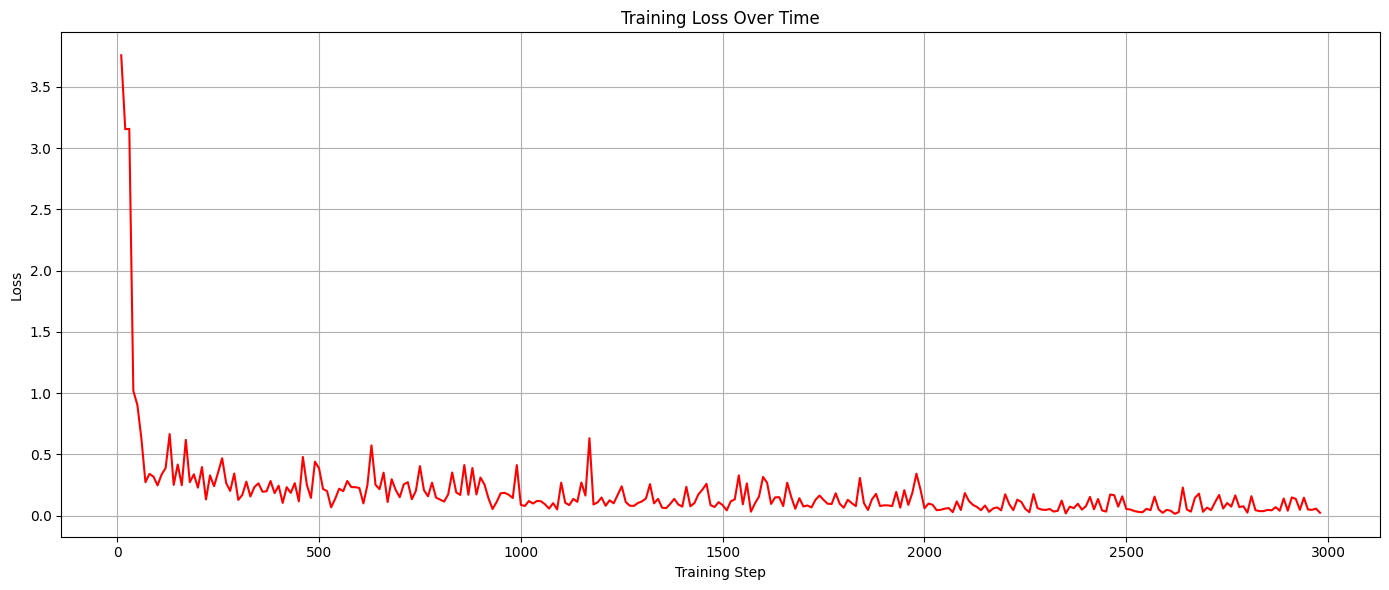

In [1]:
import matplotlib.pyplot as plt


log_data = """
10	3.757200
20	3.153600
30	3.156400
40	1.018400
50	0.903000
60	0.627900
70	0.272500
80	0.340600
90	0.317700
100	0.246600
110	0.334700
120	0.388900
130	0.665400
140	0.251000
150	0.417000
160	0.247900
170	0.618400
180	0.272600
190	0.336700
200	0.228300
210	0.395800
220	0.131600
230	0.327900
240	0.239600
250	0.351700
260	0.467800
270	0.265900
280	0.201600
290	0.343600
300	0.128400
310	0.168700
320	0.277300
330	0.156200
340	0.233100
350	0.263400
360	0.194600
370	0.198300
380	0.282300
390	0.183200
400	0.244000
410	0.103500
420	0.232100
430	0.185700
440	0.264600
450	0.116300
460	0.478600
470	0.250100
480	0.144300
490	0.440100
500	0.386800
510	0.217200
520	0.199700
530	0.067800
540	0.136600
550	0.219700
560	0.199200
570	0.282500
580	0.232800
590	0.231900
600	0.225200
610	0.099600
620	0.250500
630	0.573200
640	0.251000
650	0.215700
660	0.350400
670	0.111100
680	0.296700
690	0.209100
700	0.150000
710	0.255100
720	0.272700
730	0.133600
740	0.202200
750	0.404000
760	0.207500
770	0.157500
780	0.268500
790	0.146400
800	0.130300
810	0.114700
820	0.173100
830	0.351900
840	0.189100
850	0.168700
860	0.412600
870	0.170000
880	0.388400
890	0.172400
900	0.310600
910	0.253200
920	0.139800
930	0.053800
940	0.110600
950	0.182200
960	0.185600
970	0.170300
980	0.143800
990	0.412200
1000	0.087800
1010	0.078100
1020	0.118900
1030	0.098500
1040	0.119500
1050	0.116900
1060	0.091800
1070	0.057300
1080	0.101900
1090	0.050600
1100	0.269100
1110	0.104800
1120	0.085700
1130	0.136400
1140	0.112300
1150	0.270100
1160	0.163500
1170	0.631500
1180	0.090800
1190	0.107300
1200	0.147700
1210	0.080200
1220	0.125000
1230	0.100200
1240	0.169800
1250	0.238800
1260	0.110300
1270	0.080800
1280	0.079200
1290	0.102800
1300	0.115800
1310	0.140000
1320	0.256800
1330	0.099800
1340	0.136500
1350	0.064700
1360	0.060900
1370	0.094900
1380	0.136700
1390	0.091200
1400	0.073200
1410	0.234900
1420	0.075700
1430	0.102000
1440	0.173500
1450	0.212800
1460	0.259500
1470	0.085000
1480	0.070200
1490	0.109700
1500	0.085500
1510	0.042500
1520	0.116100
1530	0.132400
1540	0.328400
1550	0.092400
1560	0.262900
1570	0.031700
1580	0.099400
1590	0.155300
1600	0.315400
1610	0.269200
1620	0.095100
1630	0.148900
1640	0.150400
1650	0.078200
1660	0.268500
1670	0.151200
1680	0.055600
1690	0.142000
1700	0.074700
1710	0.082700
1720	0.066400
1730	0.129000
1740	0.163700
1750	0.128000
1760	0.096900
1770	0.094300
1780	0.182100
1790	0.096700
1800	0.064400
1810	0.129400
1820	0.101300
1830	0.077400
1840	0.307000
1850	0.101500
1860	0.046100
1870	0.133100
1880	0.176900
1890	0.077900
1900	0.084000
1910	0.083100
1920	0.077800
1930	0.193300
1940	0.065200
1950	0.207800
1960	0.087400
1970	0.186400
1980	0.342100
1990	0.214200
2000	0.059500
2010	0.098000
2020	0.088800
2030	0.044100
2040	0.047300
2050	0.056400
2060	0.061700
2070	0.028300
2080	0.116000
2090	0.045600
2100	0.183800
2110	0.119800
2120	0.087600
2130	0.070400
2140	0.044200
2150	0.082300
2160	0.030500
2170	0.058100
2180	0.067100
2190	0.043000
2200	0.173900
2210	0.093600
2220	0.044400
2230	0.130200
2240	0.111000
2250	0.053700
2260	0.027800
2270	0.176200
2280	0.061000
2290	0.049200
2300	0.046000
2310	0.053900
2320	0.033000
2330	0.038500
2340	0.122300
2350	0.017800
2360	0.073100
2370	0.060900
2380	0.096500
2390	0.048800
2400	0.077100
2410	0.152500
2420	0.051500
2430	0.135400
2440	0.042100
2450	0.032700
2460	0.172000
2470	0.166700
2480	0.073000
2490	0.157100
2500	0.054000
2510	0.049600
2520	0.036800
2530	0.030400
2540	0.027200
2550	0.055200
2560	0.044500
2570	0.154600
2580	0.050800
2590	0.022600
2600	0.046800
2610	0.039600
2620	0.014700
2630	0.028900
2640	0.229200
2650	0.050100
2660	0.032100
2670	0.145200
2680	0.179600
2690	0.031200
2700	0.065000
2710	0.044700
2720	0.109800
2730	0.168300
2740	0.057800
2750	0.103000
2760	0.073400
2770	0.164900
2780	0.069200
2790	0.076800
2800	0.024100
2810	0.158200
2820	0.044300
2830	0.036400
2840	0.036600
2850	0.046400
2860	0.042900
2870	0.069100
2880	0.039800
2890	0.139600
2900	0.039800
2910	0.148400
2920	0.135800
2930	0.046600
2940	0.146300
2950	0.049800
2960	0.046900
2970	0.056900
2980	0.023000
"""  


steps = []
losses = []

for line in log_data.strip().split('\n'):
    parts = line.strip().split()

    if len(parts) != 2:
        continue  





    step, loss = parts
    steps.append(int(step))
    losses.append(float(loss))


plt.figure(figsize=(14, 6))
plt.plot(steps, losses, color='red')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pip install torch

Run through cleaned_files:

In [ ]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


model_name = "facebook/bart-large-cnn"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


def summarize(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True).to(model.device)
    summary_ids = model.generate(inputs["input_ids"], max_length=256, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)



input_folder = "cleaned_files"
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        
        if df.shape[1] >= 3:
            
            df['summary'] = df.iloc[:, 2].apply(summarize)

          
            base, ext = os.path.splitext(filename)
            output_filename = f"{base}_summarized{ext}"


            output_path = os.path.join(input_folder, output_filename)
            df.to_csv(output_path, index=False)

            print(f"saved summarized file: {output_filename}")
        else:
            print(f"skipped {filename}")
